In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import statsmodels.api as sm

In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [11]:
!pip install calplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8116 sha256=e9843d005dea3b45614d93d158d1141df071f11f20853bc43327b45061483381
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.graphics.mosaicplot import mosaic
import nltk
import spacy
from spacy.matcher import PhraseMatcher
import calplot as cplt
import plotly.offline as py
import plotly.express as px
import cufflinks as cf

In [13]:
sns.set()
%matplotlib inline

In [17]:
file='/content/Africa_1997-2020_Jan08.csv'

In [18]:
africa = pd.read_csv(file, sep=';')

In [19]:
africa.tail()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP
65530,404,KEN318,318,25-octobre-1998,1998,1,Violence against civilians,Attack,OLF: Oromo Liberation Front,Borana Ethnic Militia (Kenya),...,Township,Tuli,1643,40343,1,All Africa,Regional,OLF and Borana ethnic militia attack civilians...,28,1553544833
65531,404,KEN319,319,02-novembre-1998,1998,1,Protests,Peaceful protest,Protesters (Kenya),Students (Kenya),...,Nairobi Central,Nairobi,-1283,36817,1,All Africa,Regional,University students protest over killing in Wa...,0,1567465412
65532,404,KEN320,320,10-novembre-1998,1998,1,Battles,Armed clash,SPLM/A: Sudan People's Liberation Movement/Army,NaN,...,Nairobi Central,Nairobi,-1283,36817,1,All Africa,Regional,Garangs SPLA security men raid home of Kerubin...,0,1604344065
65533,404,KEN323,323,14-novembre-1998,1998,1,Battles,Armed clash,SPLM/A: Sudan People's Liberation Movement/Army,NaN,...,Nairobi Central,Nairobi,-1283,36817,1,All Africa,Regional,Rival SPLA factions battle at police station,0,1583194169
65534,404,KEN322,322,14-novembre-1998,1998,1,Battles,Armed clash,SPLM/A: Sudan People's Liberation Movement/Army,NaN,...,Nairobi Central,Nairobi,-1283,36817,1,All Africa,Regional,Gang of youth loyal to Kerubinos SPLA faction ...,0,1583194169


In [20]:
africa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ISO               65535 non-null  int64 
 1   EVENT_ID_CNTY     65535 non-null  object
 2   EVENT_ID_NO_CNTY  65535 non-null  int64 
 3   EVENT_DATE        65535 non-null  object
 4   YEAR              65535 non-null  int64 
 5   TIME_PRECISION    65535 non-null  int64 
 6   EVENT_TYPE        65535 non-null  object
 7   SUB_EVENT_TYPE    65535 non-null  object
 8   ACTOR1            65535 non-null  object
 9   ASSOC_ACTOR_1     12768 non-null  object
 10  INTER1            65535 non-null  int64 
 11  ACTOR2            50346 non-null  object
 12  ASSOC_ACTOR_2     11167 non-null  object
 13  INTER2            65535 non-null  int64 
 14  INTERACTION       65535 non-null  int64 
 15  REGION            65535 non-null  object
 16  COUNTRY           65535 non-null  object
 17  ADMIN1      

In [21]:
africa.isnull().sum()[africa.isnull().sum()>0]

ASSOC_ACTOR_1    52767
ACTOR2           15189
ASSOC_ACTOR_2    54368
ADMIN3           13204
NOTES             2604
dtype: int64

In [22]:
africa.drop(columns=['ASSOC_ACTOR_1', 'ASSOC_ACTOR_2', 'ADMIN3', 'TIMESTAMP',
                     'EVENT_ID_NO_CNTY', 'EVENT_ID_CNTY', 'ISO'], inplace=True)

In [23]:
africa.isnull().sum()[africa.isnull().sum()>0]

ACTOR2    15189
NOTES      2604
dtype: int64

In [24]:
africa.ACTOR2.fillna(' ', inplace=True)

In [25]:
africa.dropna(inplace=True)

In [26]:
africa['LONGITUDE'] = pd.to_numeric(africa['LONGITUDE'], errors='coerce')
africa['LATITUDE'] = pd.to_numeric(africa['LATITUDE'], errors='coerce')

In [27]:
def proper_date(row):
    month = {'janvier': 1, 'février':2, 'mars':3, 'avril':4, 'mai':5,
            'juin':6, 'juillet':7, 'août':8, 'septembre':9, 'octobre':10,
            'novembre':11, 'décembre':12}
    c = row.split('-')
    date = f'{c[0]}/{month[c[1]]}/{c[2]}'
    return date

In [28]:
africa['EVENT_DATE'] = africa['EVENT_DATE'].apply(proper_date)

In [29]:
africa['EVENT_DATE'] = pd.to_datetime(africa['EVENT_DATE'])

<ipython-input-29-856ec72c020a>:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [30]:
africa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62931 entries, 0 to 65534
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   EVENT_DATE      62931 non-null  datetime64[ns]
 1   YEAR            62931 non-null  int64         
 2   TIME_PRECISION  62931 non-null  int64         
 3   EVENT_TYPE      62931 non-null  object        
 4   SUB_EVENT_TYPE  62931 non-null  object        
 5   ACTOR1          62931 non-null  object        
 6   INTER1          62931 non-null  int64         
 7   ACTOR2          62931 non-null  object        
 8   INTER2          62931 non-null  int64         
 9   INTERACTION     62931 non-null  int64         
 10  REGION          62931 non-null  object        
 11  COUNTRY         62931 non-null  object        
 12  ADMIN1          62931 non-null  object        
 13  ADMIN2          62931 non-null  object        
 14  LOCATION        62931 non-null  object        
 15  LA

In [31]:
africa['EVENT_TYPE'].value_counts()

Violence against civilians    18183
Battles                       18013
Protests                      13648
Riots                          5766
Strategic developments         5128
Explosions/Remote violence     2193
Name: EVENT_TYPE, dtype: int64

In [32]:
africa['SUB_EVENT_TYPE'].value_counts()

Armed clash                            16316
Attack                                 14803
Peaceful protest                       11247
Violent demonstration                   3702
Abduction/forced disappearance          2507
Mob violence                            2064
Looting/property destruction            1597
Protest with intervention               1493
Change to group/activity                1179
Government regains territory             998
Excessive force against protesters       908
Remote explosive/landmine/IED            899
Sexual violence                          874
Non-state actor overtakes territory      699
Grenade                                  655
Arrests                                  533
Other                                    468
Non-violent transfer of territory        454
Agreement                                391
Shelling/artillery/missile attack        348
Disrupted weapons use                    320
Headquarters or base established         185
Suicide bo

In [33]:
africa['ACTOR1'].value_counts()

Protesters (Algeria)                                               5916
Military Forces of the Democratic Republic of Congo (2001-2019)    2747
Unidentified Armed Group (Burundi)                                 2192
Unidentified Armed Group (Democratic Republic of Congo)            2095
Military Forces of Ethiopia (1995-2018)                            1962
                                                                   ... 
Tutsi Ethnic Militia (Democratic Republic of Congo)                   1
M27                                                                   1
Lokutu Communal Militia (Democratic Republic of Congo)                1
Sikilyamuba                                                           1
Bagisu Ethnic Militia (Kenya)                                         1
Name: ACTOR1, Length: 1638, dtype: int64

In [34]:
africa['ACTOR2'].value_counts()

                                                           14990
Civilians (Democratic Republic of Congo)                    7018
Civilians (Burundi)                                         5442
Civilians (Central African Republic)                        2462
Civilians (Cameroon)                                        2175
                                                           ...  
Unidentified Communal Militia (Nigeria)                        1
Lokenye Communal Militia (Democratic Republic of Congo)        1
Igboiganan Communal Militia (Benin)                            1
AAAJ: Anti-Jihadist African Alliance                           1
Mutiny of Cobras Militia                                       1
Name: ACTOR2, Length: 1394, dtype: int64

In [35]:
africa['COUNTRY'].value_counts()

Democratic Republic of Congo    18733
Algeria                          9922
Burundi                          8977
Ethiopia                         5688
Central African Republic         5126
Cameroon                         4149
Ivory Coast                      2405
Guinea                           1862
Angola                           1691
Ghana                            1154
Chad                             1070
Eritrea                           411
Republic of Congo                 326
Kenya                             316
Benin                             298
Gabon                             257
Gambia                            241
Djibouti                          159
Botswana                           77
Equatorial Guinea                  69
Name: COUNTRY, dtype: int64

In [36]:
africa['REGION'].value_counts()

Middle Africa      31421
Eastern Africa     15551
Northern Africa     9922
Western Africa      5960
Southern Africa       77
Name: REGION, dtype: int64

In [37]:
africa['ADMIN1'].value_counts()

Nord-Kivu           7322
Sud-Kivu            3458
Oromia              2899
Ituri               2180
Bujumbura Mairie    2126
                    ... 
Bomet                  1
Ogooue-Ivindo          1
M'sila                 1
Oum El Bouaghi         1
Murang'a               1
Name: ADMIN1, Length: 317, dtype: int64

In [38]:
africa['SOURCE_SCALE'].value_counts()

National                     23277
International                12330
Other                         6629
Regional                      6121
Local partner-Other           5167
New media                     2894
Subnational                   2448
National-International        1183
New media-National             742
National-Regional              419
Other-National                 268
Subnational-National           266
Subnational-Regional           230
Regional-International         206
Other-International            181
Other-Regional                 145
Other-New media                124
New media-International        109
Local partner-New media         63
New media-Subnational           55
Subnational-International       36
Other-Subnational               22
New media-Regional              16
Name: SOURCE_SCALE, dtype: int64

In [39]:
africa['SOURCE'].value_counts()

Radio Okapi                                                                5912
Undisclosed Source                                                         4263
All Africa                                                                 3937
AFP                                                                        3605
El Watan (Algeria)                                                         2753
                                                                           ... 
CCMSR; RFI; Tchad Actuel; Le Tchadanthropus; Tchadinfos; Alwihda (Chad)       1
Tchad Actuel; Alwihda (Chad)                                                  1
RFI; Tchad Actuel; Tchad Convergence                                          1
Journal du Tchad; AFP                                                         1
KTN News (Kenya)                                                              1
Name: SOURCE, Length: 4083, dtype: int64

Exploratory data anlysis

In [40]:
africa[['YEAR','LATITUDE','LONGITUDE','FATALITIES']].describe()

,YEAR,LATITUDE,LONGITUDE,FATALITIES
count,62931.000000,52280.000000,54322.000000,62931.000000
mean,2013.516836,7276.516794,19266.756452,6.009010
std,6.806783,13473.034322,13785.305126,56.801675
min,1997.000000,-24772.000000,-16771.000000,0.000000
25%,2010.000000,-2809.000000,6907.000000,0.000000
50%,2016.000000,4356.000000,24991.000000,0.000000
75%,2019.000000,9922.250000,29415.750000,1.000000
max,2021.000000,37006.000000,46181.000000,1350.000000


In [41]:
africa[['YEAR','LATITUDE','LONGITUDE','FATALITIES']].corr()

,YEAR,LATITUDE,LONGITUDE,FATALITIES
YEAR,1.000000,0.088173,-0.073827,-0.164184
LATITUDE,0.088173,1.000000,-0.567917,-0.050661
LONGITUDE,-0.073827,-0.567917,1.000000,0.037353
FATALITIES,-0.164184,-0.050661,0.037353,1.000000


In [42]:
africa.mode()

,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,...,ADMIN1,ADMIN2,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES
0,2016-06-08,2020,1,Violence against civilians,Armed clash,Protesters (Algeria),3,,7,60,...,Nord-Kivu,Beni,Bangui,4361.0,18555.0,1,Radio Okapi,National,ONLF attacks Ethiopian soldiers,0


In [43]:
africa.kurtosis()

<ipython-input-43-8f47b1bcf76f>:1: FutureWarning:

The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



YEAR               -0.199406
TIME_PRECISION     10.634839
INTER1             -0.966916
INTER2             -1.701654
INTERACTION        -1.029134
LATITUDE            0.429281
LONGITUDE          -0.685506
GEO_PRECISION       1.848211
FATALITIES        275.976573
dtype: float64

Visualization

In [45]:
obj_cols = [u  for u in africa.columns if (africa[u].dtype =='object') and (u != 'NOTES')]
int_cols = [u  for u in africa.columns if africa[u].dtype =='int']
float_cols = [u  for u in africa.columns if africa[u].dtype =='float']

In [46]:
print(f'Object columns: {obj_cols}\n\nInteger columns: {int_cols}\n\nFloat columns: {float_cols}')

Object columns: ['EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1', 'ACTOR2', 'REGION', 'COUNTRY', 'ADMIN1', 'ADMIN2', 'LOCATION', 'SOURCE', 'SOURCE_SCALE']

Integer columns: ['YEAR', 'TIME_PRECISION', 'INTER1', 'INTER2', 'INTERACTION', 'GEO_PRECISION', 'FATALITIES']

Float columns: ['LATITUDE', 'LONGITUDE']


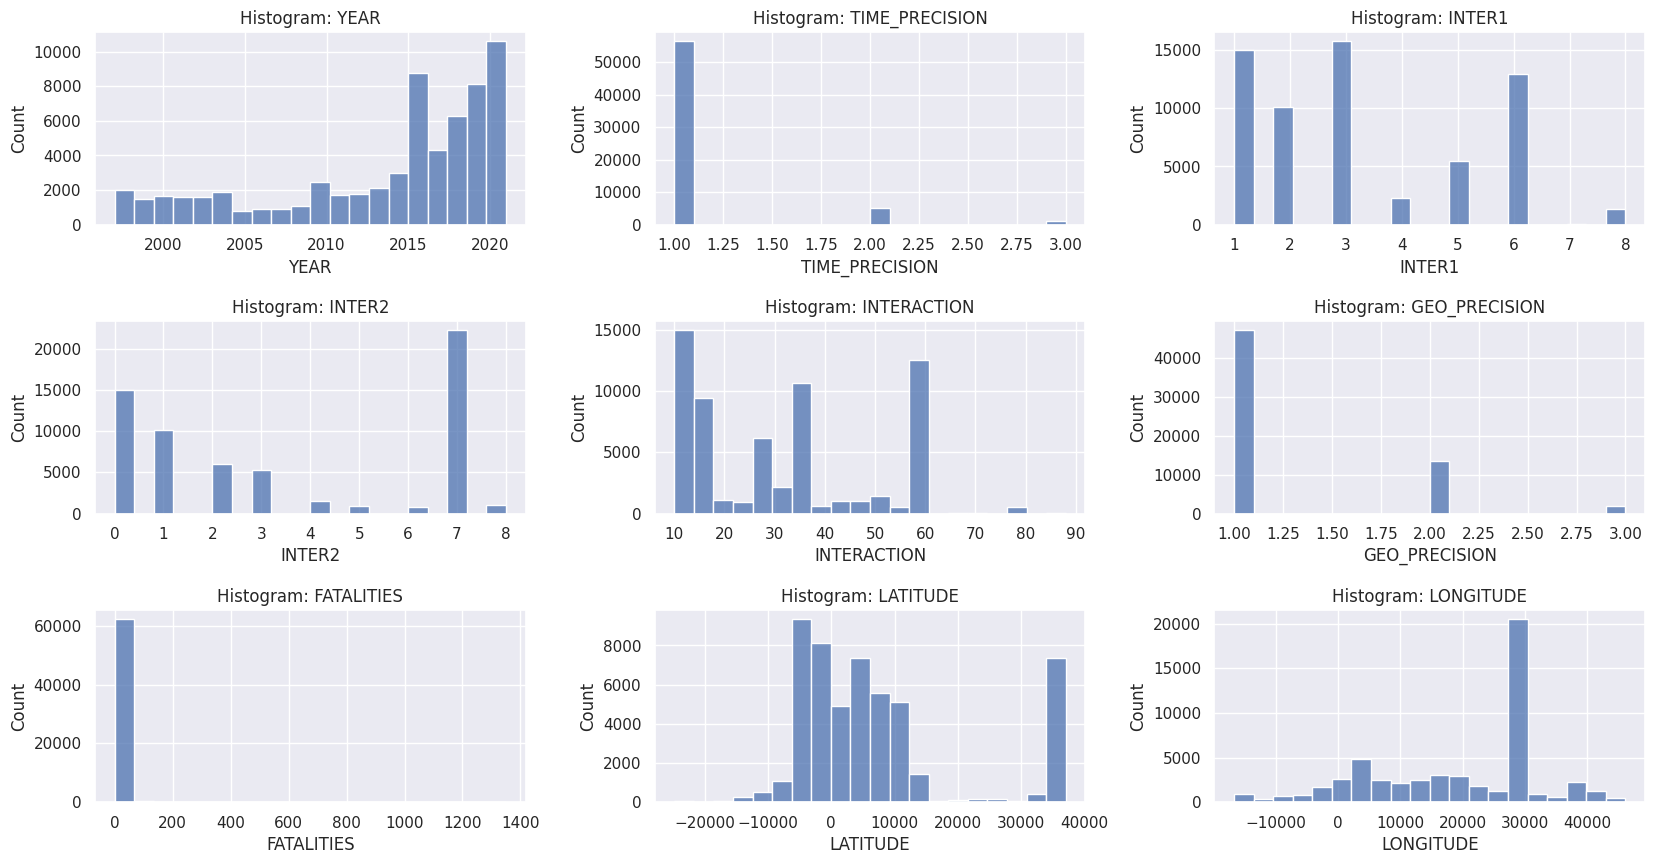

In [47]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
for i, u in enumerate(int_cols+float_cols):
    ax = fig.add_subplot(3,3,i+1)
    sns.histplot(x=u, bins=20, data=africa)
    ax.set_title('Histogram: ' +u)
plt.show()

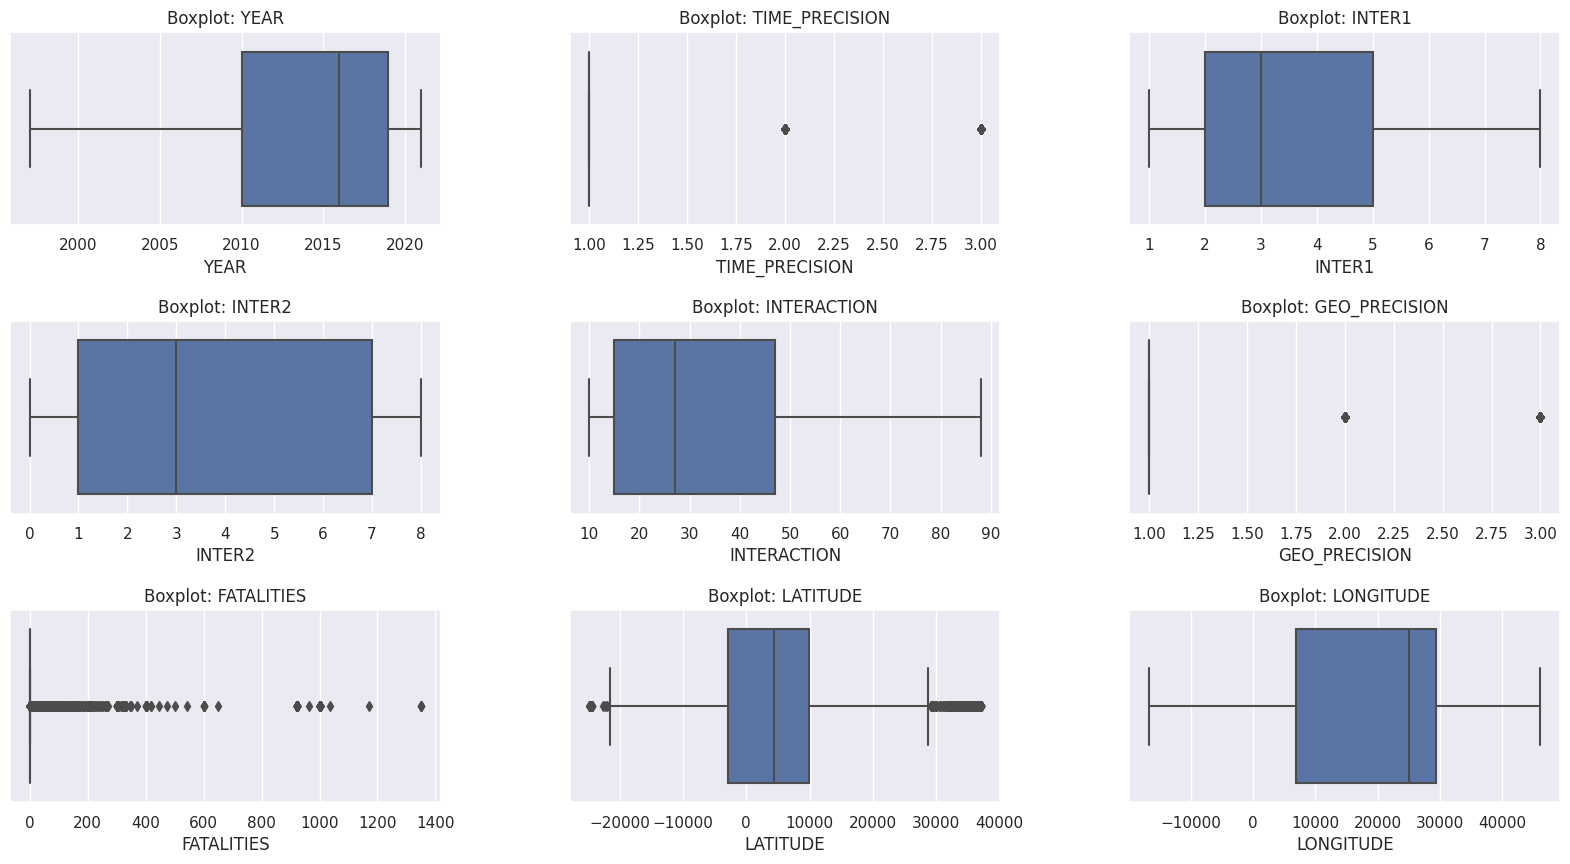

In [48]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
for i, u in enumerate(int_cols+float_cols):
    ax = fig.add_subplot(3,3,i+1)
    sns.boxplot(x=u, data=africa)
    ax.set_title('Boxplot: ' +u)
plt.show()

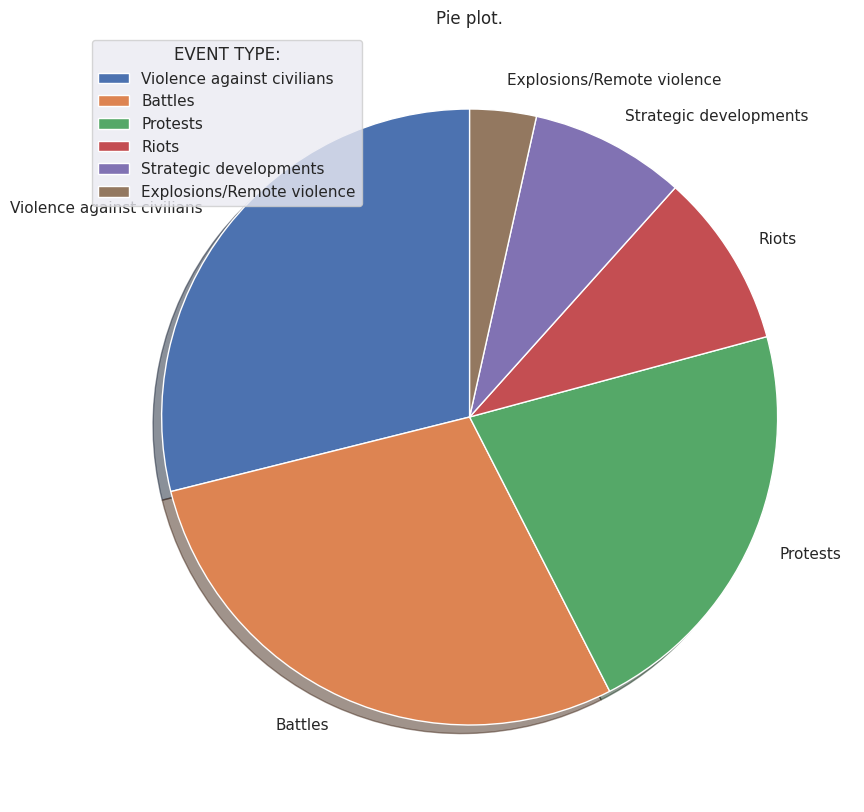

In [49]:
plt.figure(figsize=(10,10))
plt.pie(africa['EVENT_TYPE'].value_counts(), labels=africa['EVENT_TYPE'].value_counts().index, startangle=90, shadow=True)
plt.title('Pie plot.')
plt.legend(title="EVENT TYPE:", loc='upper left')
plt.show()

In [50]:
interaction = pd.pivot_table(africa, values='INTERACTION', index='INTER2', columns='INTER1', aggfunc=np.count_nonzero)

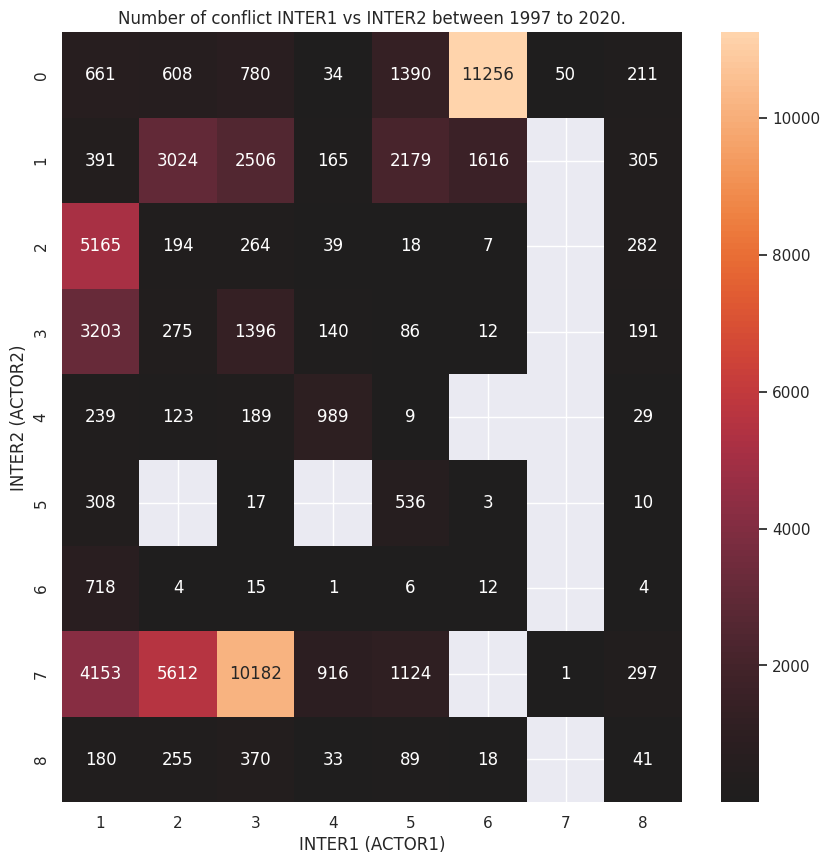

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(interaction, center=0, annot=True, fmt='.5g')
plt.title('Number of conflict INTER1 vs INTER2 between 1997 to 2020.')
plt.xlabel('INTER1 (ACTOR1)')
plt.ylabel('INTER2 (ACTOR2)')
plt.show()

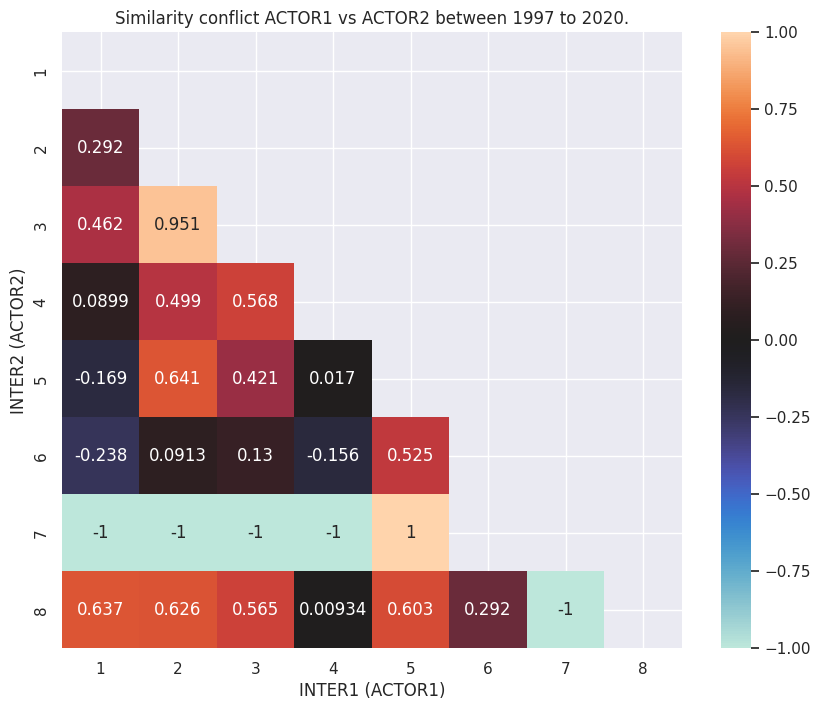

In [52]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(interaction.corr()))
sns.heatmap(interaction.corr(), center=0, annot=True, fmt='0.3g', mask=mask)
plt.title('Similarity conflict ACTOR1 vs ACTOR2 between 1997 to 2020.')
plt.xlabel('INTER1 (ACTOR1)')
plt.ylabel('INTER2 (ACTOR2)')
plt.show()

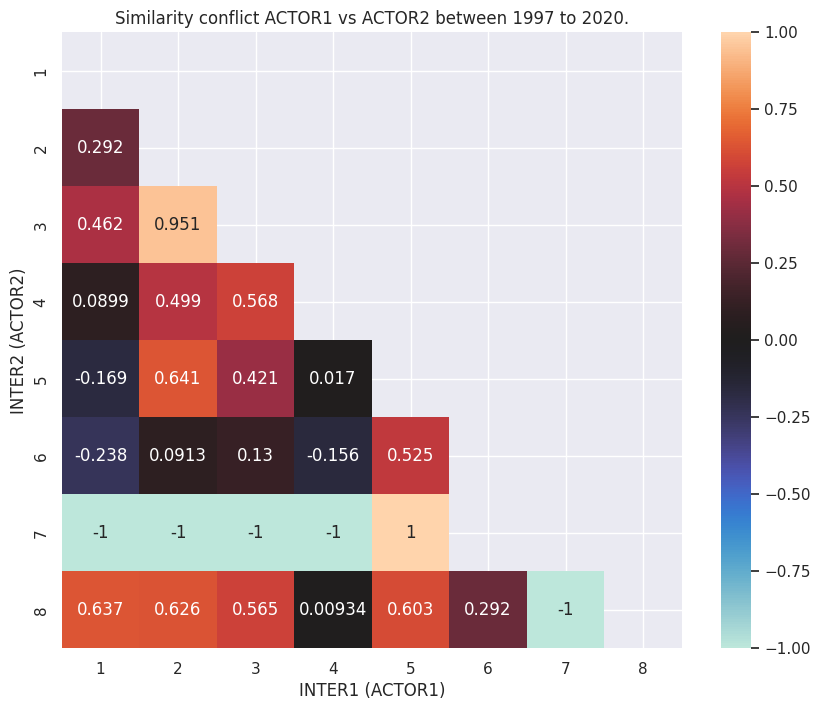

In [53]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(interaction.corr()))
sns.heatmap(interaction.corr(), center=0, annot=True, fmt='0.3g', mask=mask)
plt.title('Similarity conflict ACTOR1 vs ACTOR2 between 1997 to 2020.')
plt.xlabel('INTER1 (ACTOR1)')
plt.ylabel('INTER2 (ACTOR2)')
plt.show()

In [54]:
fatalities_interaction =  pd.pivot_table(africa, values='FATALITIES', index='INTER2', columns='INTER1', aggfunc=np.sum)

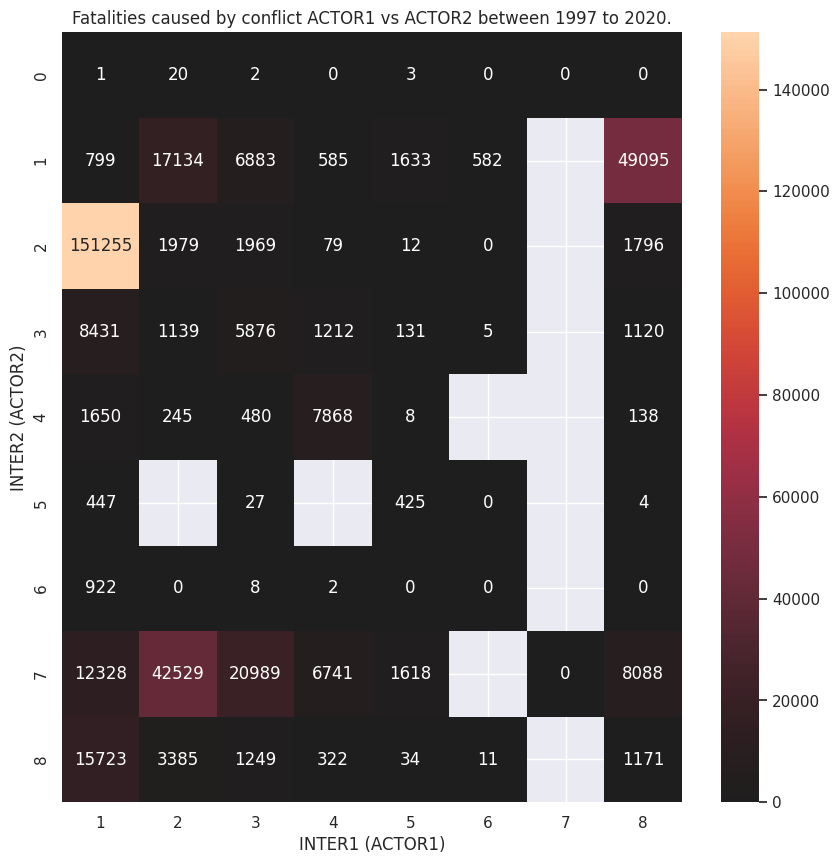

In [55]:
plt.figure(figsize=(10, 10))
sns.heatmap(fatalities_interaction, center=0, annot=True, fmt='.6g')
plt.title('Fatalities caused by conflict ACTOR1 vs ACTOR2 between 1997 to 2020.')
plt.xlabel('INTER1 (ACTOR1)')
plt.ylabel('INTER2 (ACTOR2)')
plt.show()

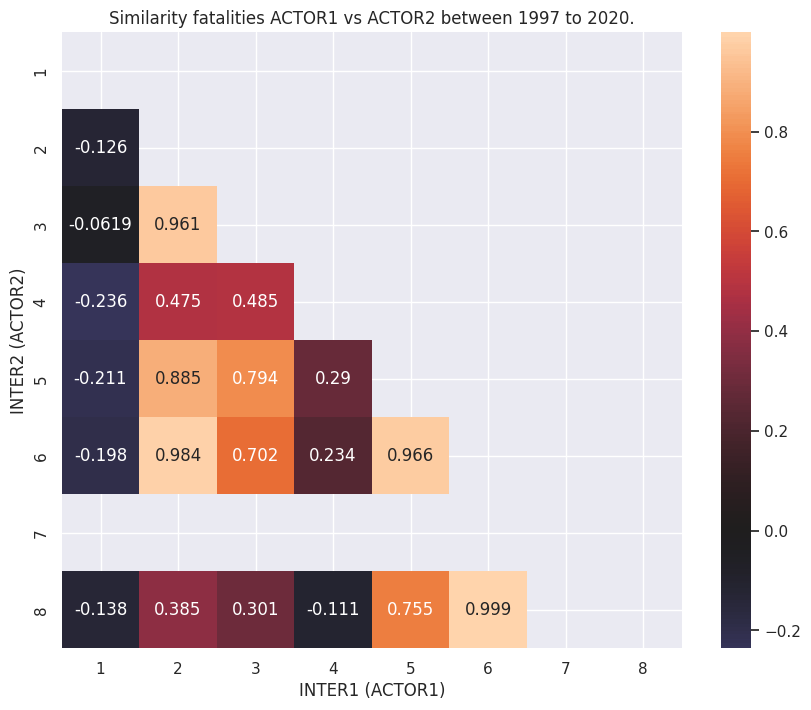

In [56]:
plt.figure(figsize=(10, 8))
mask1 = np.triu(np.ones_like(fatalities_interaction.corr()))
sns.heatmap(fatalities_interaction.corr(), center=0, annot=True, fmt='0.3g', mask=mask1)
plt.title('Similarity fatalities ACTOR1 vs ACTOR2 between 1997 to 2020.')
plt.xlabel('INTER1 (ACTOR1)')
plt.ylabel('INTER2 (ACTOR2)')
plt.show()

In each region, how many fatalities the actors make in the conflict between 1997 to 2020?

In [57]:
region_actor = pd.pivot_table(africa, values='FATALITIES', index='INTER1', columns='REGION', aggfunc=np.sum)


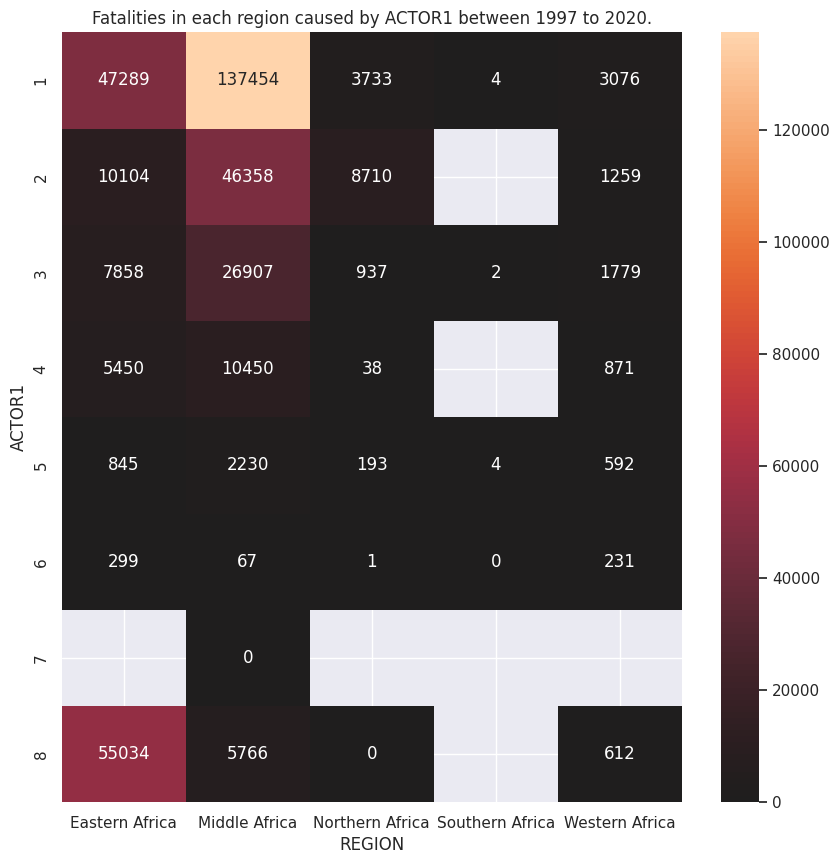

In [58]:
plt.figure(figsize=(10, 10))
sns.heatmap(region_actor, center=0, annot=True, fmt='.6g')
plt.title('Fatalities in each region caused by ACTOR1 between 1997 to 2020.')
plt.ylabel('ACTOR1')
plt.show()

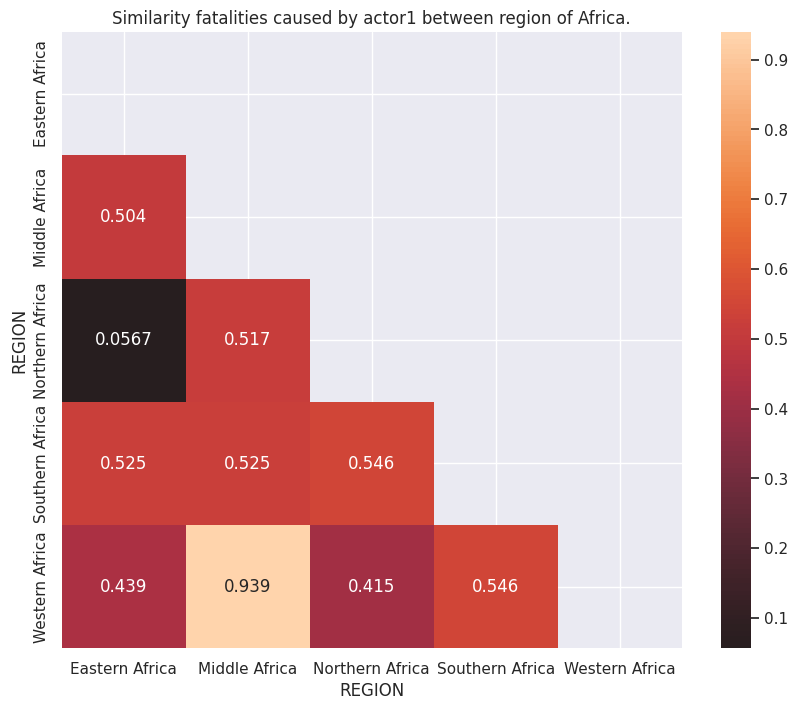

In [59]:
plt.figure(figsize=(10, 8))
mask2 = np.triu(np.ones_like(region_actor.corr()))
sns.heatmap(region_actor.corr(), center=0, annot=True, fmt='0.3g', mask=mask2)
plt.title('Similarity fatalities caused by actor1 between region of Africa.')
plt.show()

In each type of conflict event, how many fatalities the actors make between 1997 to 2020?

In [60]:
event_actor = pd.pivot_table(africa, values='FATALITIES', index='INTER1', columns='EVENT_TYPE', aggfunc=np.sum)

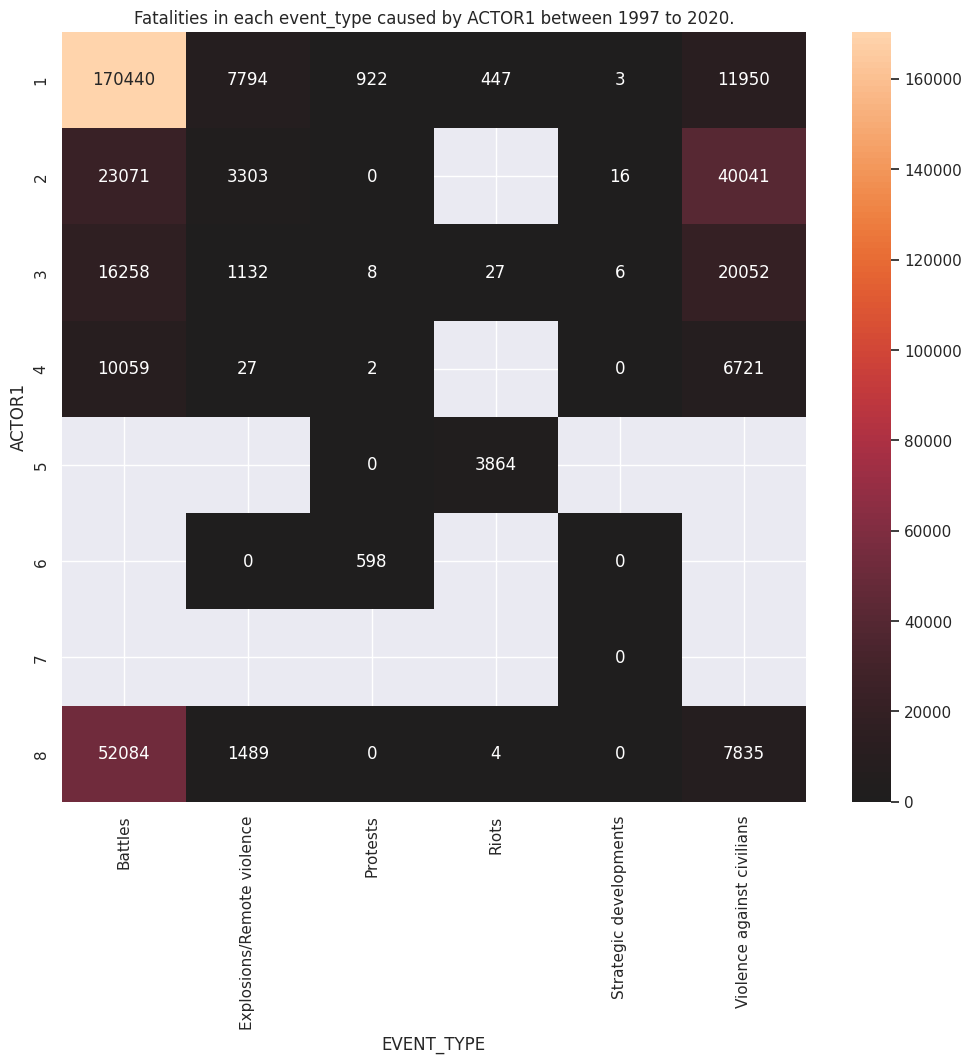

In [61]:
plt.figure(figsize=(12, 10))
sns.heatmap(event_actor, center=0, annot=True, fmt='.6g')
plt.title('Fatalities in each event_type caused by ACTOR1 between 1997 to 2020.')
plt.ylabel('ACTOR1')
plt.show()

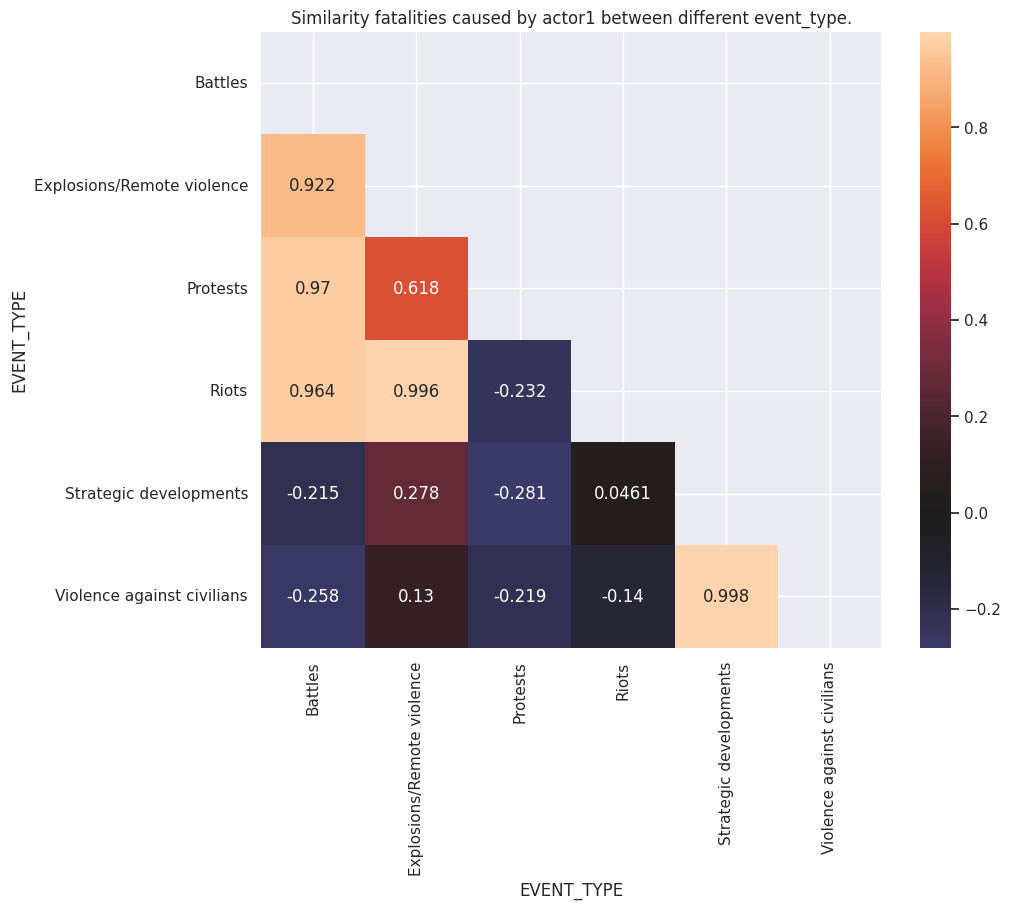

In [62]:
plt.figure(figsize=(10, 8))
mask3 = np.triu(np.ones_like(event_actor.corr()))
sns.heatmap(event_actor.corr(), center=0, annot=True, fmt='0.3g', mask=mask3)
plt.title('Similarity fatalities caused by actor1 between different event_type.')
plt.show()

In each region, how many fatalities are there in each type of conflict event between 1997 to 2020?

In [63]:
event_region = pd.pivot_table(africa, values='FATALITIES', index='REGION', columns='EVENT_TYPE', aggfunc=np.sum)

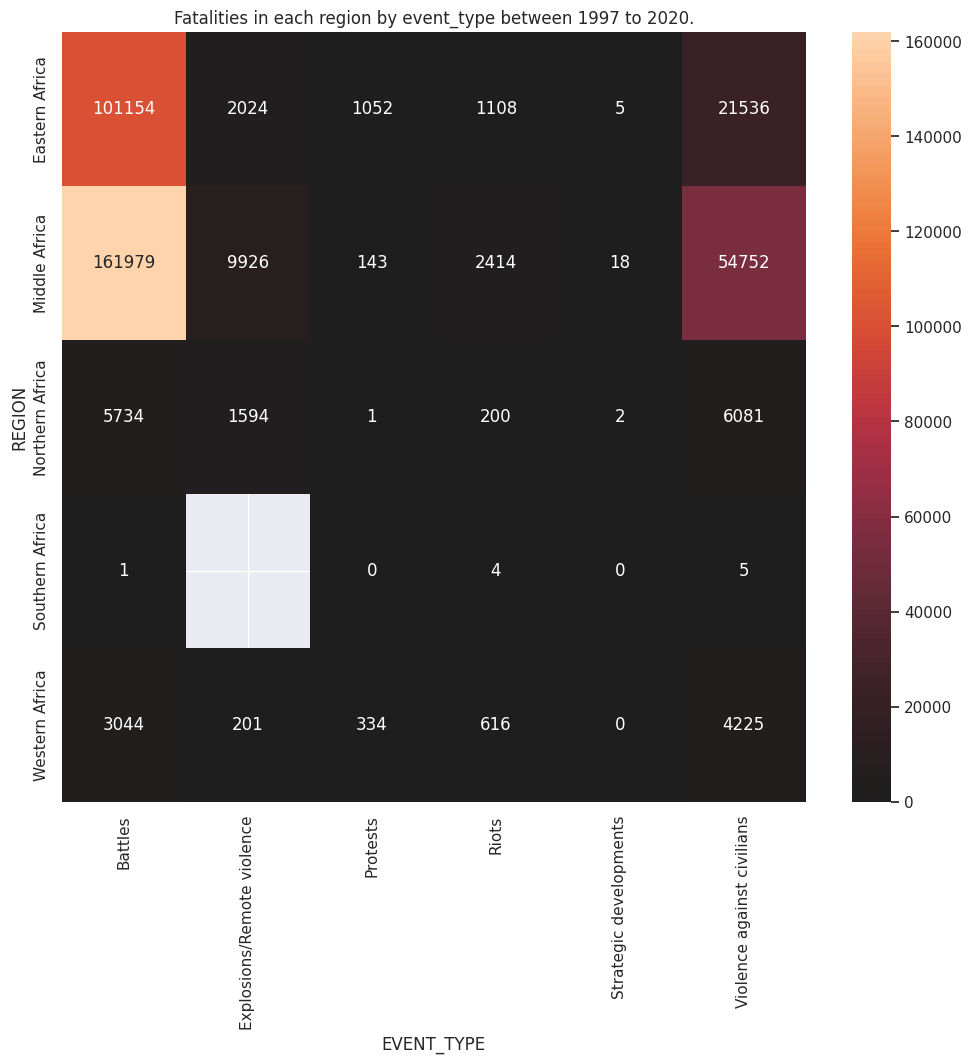

In [64]:
plt.figure(figsize=(12, 10))
sns.heatmap(event_region, center=0, annot=True, fmt='.6g')
plt.title('Fatalities in each region by event_type between 1997 to 2020.')
plt.show()

Geospatial Analysis

In [65]:
middle_africa = africa[africa['REGION'] == 'Middle Africa']

In [66]:
middle_africa.head()

,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,...,ADMIN1,ADMIN2,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES
9936,1997-01-01,1997,3,Violence against civilians,Attack,UNITA: National Union for the Total Independen...,2,Civilians (Angola),7,27,...,Bie,Kuito,Kuito,-12383.0,16933.0,3,Diario de Noticias (Angola),National,The total number of chiefs in the past 6 month...,10
9937,1997-01-01,1997,3,Violence against civilians,Attack,UNITA: National Union for the Total Independen...,2,Civilians (Angola),7,27,...,Bie,Chitembo,Mumbue,NaN,NaN,1,Angola Cronologia,National,30 cadavers found October 14,30
9938,1997-01-19,1997,1,Strategic developments,Looting/property destruction,FLEC: Front for the Liberation of the Enclave ...,2,,0,20,...,Cabinda,Cabinda,Cabinda,-5576.0,12187.0,3,Africa Research Bulletin,Other,Property destruction: Malongo oil terminal tar...,0
9939,1997-01-30,1997,2,Violence against civilians,Attack,Military Forces of Angola (1975-),1,Civilians (Angola),7,17,...,Cabinda,Belize,Caio Guembo,-4583.0,12867.0,2,Publico (Portugal),International,"FAA burns Talibeka and Tadikuma villages, loca...",0
9941,1997-05-02,1997,1,Battles,Government regains territory,Military Forces of Angola (1975-),1,UNITA: National Union for the Total Independen...,2,12,...,Bie,Kuito,Kuito,-12383.0,16933.0,3,Angola Cronologia,National,Violence in Kuito continues. Unita accuses FAA...,1000


In [67]:
middle_africa['EVENT_TYPE'].value_counts()


Battles                       11334
Violence against civilians    10794
Strategic developments         3441
Protests                       3113
Riots                          2049
Explosions/Remote violence      690
Name: EVENT_TYPE, dtype: int64

In [68]:
middle_africa['SUB_EVENT_TYPE'].value_counts()

Armed clash                            9842
Attack                                 8036
Peaceful protest                       2244
Abduction/forced disappearance         2051
Looting/property destruction           1245
Violent demonstration                  1226
Government regains territory            923
Mob violence                            823
Change to group/activity                730
Sexual violence                         708
Protest with intervention               661
Non-state actor overtakes territory     569
Non-violent transfer of territory       420
Agreement                               308
Other                                   245
Arrests                                 240
Remote explosive/landmine/IED           225
Excessive force against protesters      208
Shelling/artillery/missile attack       172
Headquarters or base established        161
Suicide bomb                            123
Grenade                                  94
Disrupted weapons use           

In [69]:
middle_africa['COUNTRY'].value_counts()

Democratic Republic of Congo    18733
Central African Republic         5126
Cameroon                         4149
Angola                           1691
Chad                             1070
Republic of Congo                 326
Gabon                             257
Equatorial Guinea                  69
Name: COUNTRY, dtype: int64

In [70]:
middle_africa['INTER1'].value_counts()

3    9629
1    7592
2    6994
6    2961
5    1940
4    1311
8     943
7      51
Name: INTER1, dtype: int64

In [71]:
middle_africa['INTERACTION'].value_counts()

37    5569
12    4445
27    4169
13    3601
60    2256
17    1880
33    1180
15     836
16     836
47     545
30     538
38     510
57     509
20     464
28     452
50     449
44     427
23     420
10     316
34     303
11     213
78     192
80     191
14     187
18     157
24     156
22     155
55     110
58      80
48      55
70      50
35      45
88      37
40      31
68      18
25      16
36       7
26       6
45       4
66       2
56       2
46       1
77       1
Name: INTERACTION, dtype: int64

In [72]:
middle_africa['ACTOR1'].value_counts()[middle_africa['ACTOR1'].value_counts()>100]

Military Forces of the Democratic Republic of Congo (2001-2019)                                       2747
Unidentified Armed Group (Democratic Republic of Congo)                                               2085
Protesters (Democratic Republic of Congo)                                                             1808
LRA: Lords Resistance Army                                                                            1288
Islamic State (West Africa) and/or Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad           1254
Rioters (Democratic Republic of Congo)                                                                1200
Military Forces of Angola (1975-)                                                                      941
Military Forces of the Democratic Republic of Congo (2019-)                                            921
Military Forces of Cameroon (1982-)                                                                    898
Unidentified Armed Group (Central Afr

In [73]:
need_cols = ["ACTOR1", "ACTOR2", "REGION", "COUNTRY", "ADMIN1", "ADMIN2",
             "LOCATION", "EVENT_TYPE", "SUB_EVENT_TYPE", "FATALITIES", "YEAR",
             "LONGITUDE","LATITUDE", "INTERACTION"]

In [74]:
ext_data = africa[need_cols]

In [75]:
year_data = ext_data[ext_data['YEAR'] == 2020]

In [76]:
center_point = dict(lon=3, lat=11)
figx = px.density_mapbox(ext_data, lat='LATITUDE', lon='LONGITUDE', z="FATALITIES",
                        center = center_point, hover_name='COUNTRY', zoom = 5,
                         range_color= [20, 20] , radius=20,
                        mapbox_style= 'open-street-map', title='Conflict in Africa between 1997 and 2020',
                        animation_frame='YEAR')
figx.update(layout_coloraxis_showscale=True)
figx.show()

Text mining

In [78]:
def tokenizer(text):

    def is_token_allowed(token):
        if(not token or token.is_stop or token.is_punct):
            return False
        return True

    def preprocess_token(token):
        return token.lemma_.strip().lower()

    nlp = spacy.load("en_core_web_sm")

    doc = nlp(text)

    filtered_token = [preprocess_token(token) for token in doc if is_token_allowed(token)]

    return filtered_token


In [79]:
year_country = africa[(africa['YEAR'] == 2008) & (africa['COUNTRY'] == 'Cameroon')]


In [80]:
text1 = ' '.join(year_country['NOTES'])
text = tokenizer(text1)

In [81]:
source = ' '.join(year_country['SOURCE'])

In [83]:
event = ' '.join(year_country['EVENT_TYPE'])

In [84]:
actors = ' '.join(year_country['ACTOR1'] + ', ' + year_country['ACTOR2'])

Text statistics

In [85]:
print(f'Lenght of the text: {len(text)}.')

Lenght of the text: 438.


In [86]:
print(f'Lexical richness of the text: {len(text)/len(set(np.unique(text)))}.')

Lexical richness of the text: 2.591715976331361.


In [87]:
fdist = nltk.FreqDist(text)

In [88]:
fdist

FreqDist({'protest': 17, 'cameroonian': 15, 'soldier': 13, 'bakassi': 11, 'police': 11, 'high': 10, 'cost': 10, 'nigerian': 9, 'attack': 9, 'respond': 8, ...})

In [89]:
popular_word = list(set(fdist.keys()) - set(fdist.hapaxes()))

In [90]:
pop_word = pd.Series({w:fdist[w] for w in sorted(popular_word)})

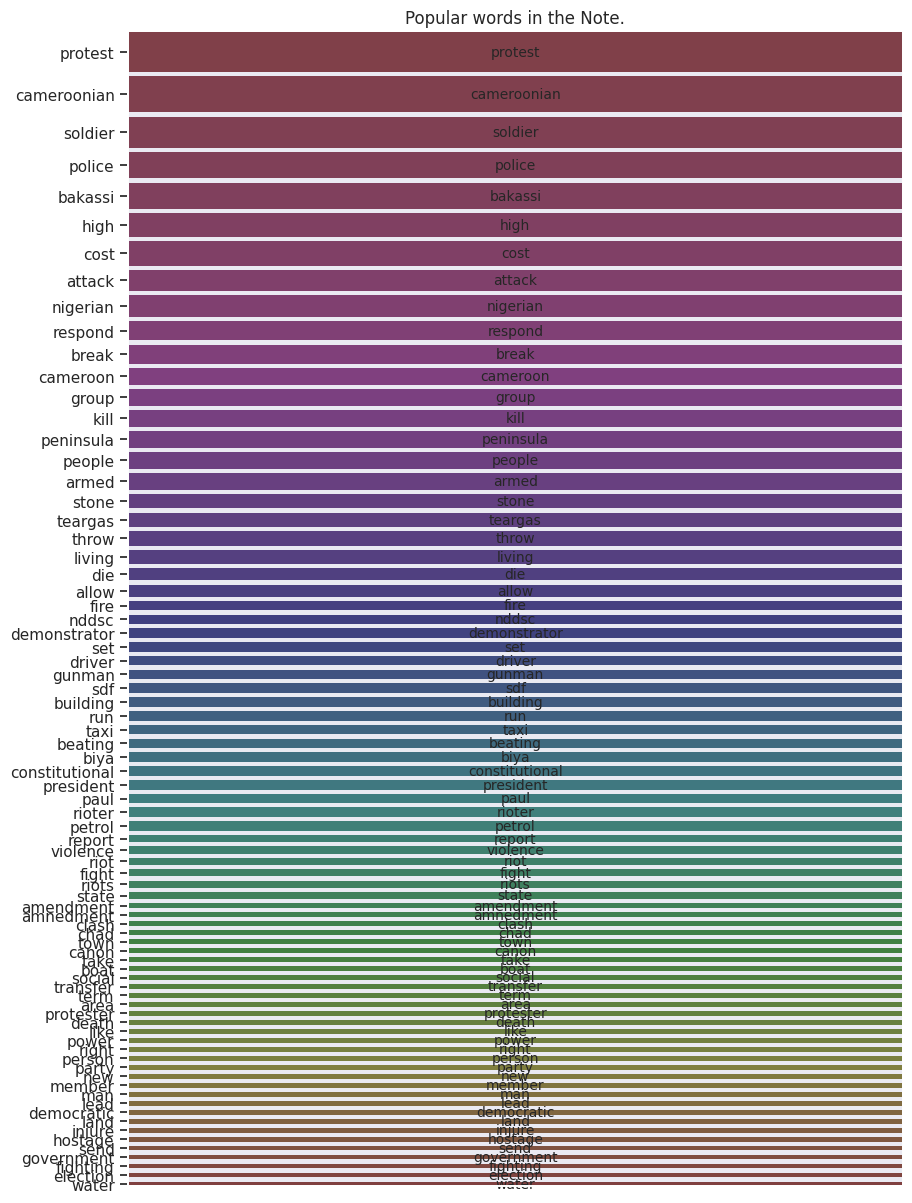

In [91]:
fig, ax = plt.subplots(figsize=(10,15))
mosaic(pop_word.sort_values(), ax=ax, horizontal=False, title='Popular words in the Note.')
plt.show()